<a href="https://colab.research.google.com/github/X-Xin6/DeLIVR/blob/main/Stage1_DeLiVR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
def standardize_data(X):
	mean = np.mean(X,axis=0)
	std = np.std(X, axis=0)
	return (X-mean)/std

# Simulate data for two-stage experiment
def generate_data(IV, beta, true_g, gamma, seed = 0):
	if seed is None:
		seed = np.random.randint(0,2**32 - 1)
	np.random.seed(seed)
 	#select 10% for first-stage sample
	s1_size = IV.shape[0]//10
	#The indices for stage 1 and stage 2
	s1_idx = np.random.choice(np.arange(IV.shape[0]), size = s1_size, replace = False)
	print(s1_idx)
	s2_idx = np.array(list(set(np.arange(IV.shape[0])).difference(s1_idx)))
	print(s2_idx)
	# stage 1 data and stage2 data
	s1_Z = IV[s1_idx,:]
	s2_Z = IV[s2_idx,:]
	#X=z*beta + error 1
	s1_X = (s1_Z@beta).squeeze() + np.random.normal(size = s1_size)
	s1_X = s1_X.reshape(-1,1)
 # The Correlation Representing Confounding
	e = np.random.multivariate_normal(mean = [0,0], cov = [[1,gamma],[gamma,1]], size = s2_Z.shape[0])
  #s2_X=s2_Z⋅β+e:,0 X=Z*beta+U
	s2_X = (s2_Z@beta).squeeze() + e[:,0]
	#Y=Y(s2_X)+e:,1 Y=g(X)+U
	Y = true_g(s2_X) + e[:,1]
	s2_X = s2_X.reshape(-1,1)

	return s1_Z, s1_X, s2_Z, Y,s2_X

In [ ]:
def fit_stage1(s1_Z, s1_X,s2_Z):
    design = sm.add_constant(s1_Z)
    #we find the estimated beta by fitting stage1 model
    stage1 = sm.OLS(s1_X, design).fit()
    s2_design = sm.add_constant(s2_Z)
    # we estimate X by plugging the stage 2 data. s2_X=s2_Z⋅β_hat; X_hat=Z*beta_hat
    s2_X = stage1.predict(s2_design).reshape(-1, 1)
    return s2_X,stage1.params

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[9394  898 2398 5906 2343 8225 5506 6451 2670 3497 1087 1819 2308 6084
 3724 3184 6387 3728 2702 7883 2930 5988 4890 6718 5423 3213 3017  382
 4237 4721 9547 9477 4795 4747 9366 5334 6652 9032  580 9491 6526 4346
 4974 7913 5611 8480 6625 5615 5602 4857 6734 8451 6332 6798 5313 2821
 9300 2375 1478 5013 1559 8885 3986 4429 3951 2932 6419  713 8089 6058
 8711 4185 4379 7813  843  655 7219  982 7439 8894  598 5350 4221 1422
 3646 4387 2606 4228 1096 8940 5814 3706 2846  467 8314 4595 3725 6450
 6846 3891 7407 5892 5301 4808 8148 3931 9672 1312 1942  841 5792 3683
 8876 5660 4447 3066 8135 5957 4678 2869 2535 5482 4302 5608 7527 1534
 8110 6699 4696 2580 7178 4644 4858 5946 9822 4673 3341 1376 9320 6275
 1308 7569 7358 2252 9892 8830 7980 8850 9345 9276  521 3232  226 3953
 1427 8748 8060 5525  167 1103 9089 6759 7648 5473 2376  296 1785 7684
 7174 4700 5657 649

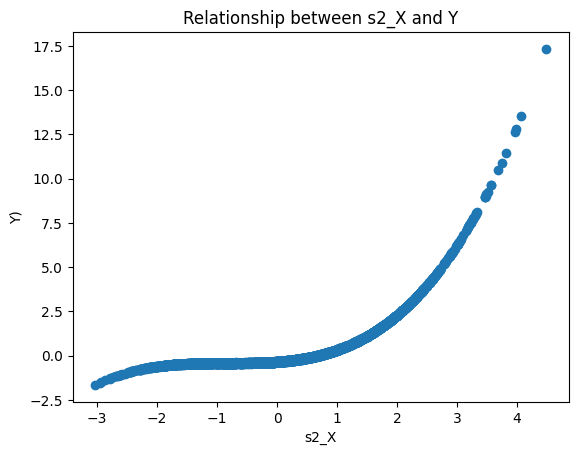

In [ ]:
#save data files to csv
from google.colab import drive
import pandas as pd
import tensorflow as tf

def save_tensor_to_drive_tensorflow(tensor, filename, drive_path="/content/drive/MyDrive/colab_data/"):
    # Mount Google Drive
    drive.mount('/content/drive', force_remount=True)

    # Convert TensorFlow tensor to a numpy array
    numpy_array = tensor.numpy()

    # Convert to DataFrame
    df = pd.DataFrame(numpy_array)

    # Full path
    full_path = drive_path + filename

    # Save to CSV
    df.to_csv(full_path, index=False)
    print(f"File saved to {full_path}")
from google.colab import drive
import numpy as np

def save_array_to_drive_csv(array, filename, drive_folder="/content/drive/MyDrive/colab_data/"):
    """
    Saves a NumPy array to a CSV file in Google Drive.
    """
    # Mount Google Drive
    drive.mount('/content/drive')

    # Ensure filename ends with .csv
    if not filename.endswith('.csv'):
        filename += '.csv'

    # Full file path
    full_path = drive_folder + filename

    # Save array as CSV
    np.savetxt(full_path, array, delimiter=',')

    print(f"Array saved to {full_path}")

import torch
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from torch import nn, optim
import matplotlib.pyplot as plt
#data simulation test
#Data Simulation
# Load data
from google.colab import drive
drive.mount("/content/drive")

simulated_IV = pd.read_csv('/content/drive/MyDrive/colab_data/simulated_IV.txt', sep=' ',header=None).values
s1_beta = pd.read_csv('/content/drive/MyDrive/colab_data/s1_beta.txt', sep=' ',header=None).values.squeeze()
true_g = lambda x: x**3
gamma = 0.7
#We generate X with X= Z*beta+U+error1
s1_Z, s1_X, s2_Z, Y,s2_X = generate_data(simulated_IV, s1_beta, true_g, gamma)
#standardize true Z,X, and Y
s1_Z=standardize_data(s1_Z)
s1_X=standardize_data(s1_X)
s2_Z=standardize_data(s2_Z)
Y=standardize_data(Y)
s2_X=standardize_data(s2_X)
save_array_to_drive_csv(s1_Z,"s1_Z_3.csv")
save_array_to_drive_csv(s2_Z,"s2_Z_3.csv")
save_array_to_drive_csv(s1_X,"s1_X_3.csv")
save_array_to_drive_csv(s2_X,"s2_X_3.csv")
save_array_to_drive_csv(Y,"Y_3.csv")
#s2_X_hat is x_hat, which is fitted data from stage1
s2_X_hat,stage1_params = fit_stage1(s1_Z, s1_X, s2_Z)
save_array_to_drive_csv(s2_X_hat,"s2_X_hat_3.csv")

# Plot the printgenerated IVs (X) against the fitted values from stage 1
plt.scatter(s2_X, Y)
#plot std data
#plt.scatter(s2_X_hat_std, s2_X)
plt.xlabel('s2_X')
plt.ylabel('Y)')
plt.title('Relationship between s2_X and Y')
plt.show()


In [ ]:
def sample_split(X, Y, test_ratio, val_ratio, seed=None):
    if seed is None:
        seed = np.random.randint(0, 2**32 - 1)

    # Split the data into training and validation + test sets
    X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=val_ratio + test_ratio, random_state=seed)

    # Calculate the proportion of the test set relative to the combined validation and test sets
    test_ratio_adjusted = test_ratio / (val_ratio + test_ratio)

    # Split the validation + test sets into separate validation and test sets
    X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=test_ratio_adjusted, random_state=seed)

    return X_train, X_val, X_test, Y_train, Y_val, Y_test



Mounted at /content/drive
File saved to /content/drive/MyDrive/colab_data/X_train.csv
Mounted at /content/drive
File saved to /content/drive/MyDrive/colab_data/y_train.csv


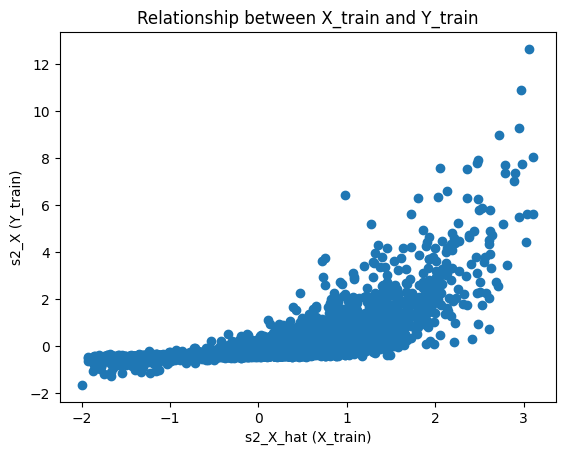

In [ ]:
    test_ratio = 0.4
    val_ratio = 0.1

    X_train, X_val, X_test, Y_train, Y_val, Y_test = sample_split(s2_X_hat, Y, test_ratio, val_ratio)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)
    Y_val_tensor = torch.tensor(Y_val, dtype=torch.float32)
    Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32)
    import matplotlib.pyplot as plt
    plt.scatter(X_train_tensor.numpy(), Y_train_tensor.numpy())
    #plot std data
    #plt.scatter(s2_X_hat_std, s2_X)
    save_tensor_to_drive_tensorflow(X_train_tensor, filename="X_train.csv")
    save_tensor_to_drive_tensorflow(Y_train_tensor, filename="y_train.csv")
    plt.xlabel('s2_X_hat (X_train)')
    plt.ylabel('s2_X (Y_train)')
    plt.title('Relationship between X_train and Y_train')
    plt.show()